In [5]:
import os
import numpy as np
import shutil
import hashlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

In [6]:
dataset_dirs = {
    "train": "../input/lungs-disease-dataset-4-types/Lung Disease Dataset/train/",
    "val": "../input/lungs-disease-dataset-4-types/Lung Disease Dataset/val/",
    "test": "../input/lungs-disease-dataset-4-types/Lung Disease Dataset/test/"
}

In [7]:
cleaned_base_dir = "./cleaned_dataset/"
os.makedirs(cleaned_base_dir, exist_ok=True)

# **Cleaning Dataset**

In [8]:
def clean_and_copy_dataset(source_dir, dest_dir):
    os.makedirs(dest_dir, exist_ok=True)  # Create destination directory if not exists
    
    hash_dict = {}  # Store image hashes to detect duplicates
    total_images, corrupted_images, duplicate_images = 0, 0, 0

    for root, _, files in os.walk(source_dir):
        rel_path = os.path.relpath(root, source_dir)  # Get relative path
        dest_folder = os.path.join(dest_dir, rel_path)  # Corresponding cleaned folder
        os.makedirs(dest_folder, exist_ok=True)  # Create subfolder in cleaned directory

        for file in files:
            img_path = os.path.join(root, file)
            new_img_path = os.path.join(dest_folder, file)
            total_images += 1
            
            # Check for corruption
            try:
                with Image.open(img_path) as img:
                    img.verify()  # Verify image integrity
            except (IOError, SyntaxError):
                corrupted_images += 1
                continue  # Skip this image
            
            # Compute hash to check for duplicates
            with open(img_path, "rb") as f:
                img_hash = hashlib.md5(f.read()).hexdigest()

            if img_hash in hash_dict:
                duplicate_images += 1
                continue  # Skip duplicate image
            else:
                hash_dict[img_hash] = new_img_path
                shutil.copy2(img_path, new_img_path)  # Copy valid unique image to new directory

    return total_images, corrupted_images, duplicate_images, total_images - corrupted_images - duplicate_images

In [9]:
original_counts, corrupted_counts, duplicate_counts, final_counts = {}, {}, {}, {}

for split, source_path in dataset_dirs.items():
    print(f"Cleaning {split} dataset...")
    
    dest_path = os.path.join(cleaned_base_dir, split)
    original_total, corrupted_removed, duplicate_removed, final_total = clean_and_copy_dataset(source_path, dest_path)

    # Store statistics
    original_counts[split] = original_total
    corrupted_counts[split] = corrupted_removed
    duplicate_counts[split] = duplicate_removed
    final_counts[split] = final_total

Cleaning train dataset...
Cleaning val dataset...
Cleaning test dataset...


In [10]:
print("\nCleaning Summary:")
for split in dataset_dirs.keys():
    print(f"\n{split.capitalize()} Set:")
    print(f"Original Images: {original_counts[split]}")
    print(f"Corrupted Removed: {corrupted_counts[split]}")
    print(f"Duplicates Removed: {duplicate_counts[split]}")
    print(f"Final Cleaned Images: {final_counts[split]}")


Cleaning Summary:

Train Set:
Original Images: 6054
Corrupted Removed: 0
Duplicates Removed: 5
Final Cleaned Images: 6049

Val Set:
Original Images: 2016
Corrupted Removed: 0
Duplicates Removed: 0
Final Cleaned Images: 2016

Test Set:
Original Images: 2025
Corrupted Removed: 0
Duplicates Removed: 0
Final Cleaned Images: 2025


# **Data Normalization**

In [11]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

In [12]:
cleaned_dataset_dirs = {
    "train": "./cleaned_dataset/train/",
    "val": "./cleaned_dataset/val/",
    "test": "./cleaned_dataset/test/"
}

In [13]:
def load_and_normalize_images(dataset_dir, target_size=(224, 224)):
    images = []  # Store normalized images
    labels = []  # Store corresponding labels
    class_names = sorted(os.listdir(dataset_dir))  # Get class labels

    for label in class_names:
        class_dir = os.path.join(dataset_dir, label)
        if not os.path.isdir(class_dir):
            continue

        for img_name in tqdm(os.listdir(class_dir), desc=f"Processing {label}"):
            img_path = os.path.join(class_dir, img_name)

            # Load image using OpenCV (convert to RGB)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Resize image to target size
            img = cv2.resize(img, target_size)

            # Normalize pixel values to range [0,1]
            img = img.astype("float32") / 255.0  

            # Append to dataset
            images.append(img)
            labels.append(label)

    return np.array(images), np.array(labels)

In [14]:
print("Normalizing Train Set...")
X_train, y_train = load_and_normalize_images(cleaned_dataset_dirs["train"])

print("\nNormalizing Validation Set...")
X_val, y_val = load_and_normalize_images(cleaned_dataset_dirs["val"])

print("\nNormalizing Test Set...")
X_test, y_test = load_and_normalize_images(cleaned_dataset_dirs["test"])

Normalizing Train Set...


Processing Viral Pneumonia: 100%|██████████| 1204/1204 [00:09<00:00, 133.48it/s]



Normalizing Validation Set...


Processing Viral Pneumonia: 100%|██████████| 401/401 [00:02<00:00, 135.44it/s]



Normalizing Test Set...


Processing Viral Pneumonia: 100%|██████████| 403/403 [00:03<00:00, 133.26it/s]


In [15]:
print("\nDataset Shapes:")
print(f"  X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"  X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"  X_test: {X_test.shape}, y_test: {y_test.shape}")


Dataset Shapes:
  X_train: (6049, 224, 224, 3), y_train: (6049,)
  X_val: (2016, 224, 224, 3), y_val: (2016,)
  X_test: (2025, 224, 224, 3), y_test: (2025,)


# **Data Transformation**

In [16]:
import os
import shutil
from PIL import Image
from tqdm import tqdm

In [17]:
cleaned_dataset_dir = "./cleaned_dataset/"

In [18]:
# Standard image size for DenseNet201
image_size = 224

In [19]:
# Function to resize and convert all images in the dataset
def transform_images(input_dir):
    for dataset_type in ["train", "val", "test"]:
        dataset_path = os.path.join(input_dir, dataset_type)

        for category in os.listdir(dataset_path):
            category_path = os.path.join(dataset_path, category)

            for img_name in tqdm(os.listdir(category_path), desc=f"Processing {category}"):
                img_path = os.path.join(category_path, img_name)
                
                try:
                    # Open image
                    img = Image.open(img_path).convert("RGB")

                    # Resize image using LANCZOS resampling (fixes the error)
                    resized_img = img.resize((image_size, image_size), Image.Resampling.LANCZOS)

                    # Save back in JPEG format
                    resized_img.save(img_path, "JPEG")
                
                except Exception as e:
                    print(f"Error processing {img_name}: {e}")

In [20]:
transform_images(cleaned_dataset_dir)

print("Transformation process completed successfully.")

Processing Bacterial Pneumonia: 100%|██████████| 403/403 [00:06<00:00, 64.11it/s]

Transformation process completed successfully.


# **Data Augmentation**

In [21]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

2025-04-26 19:11:59.841882: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745694720.099688      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745694720.176457      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [22]:
cleaned_dataset_dir = "./cleaned_dataset/"

In [23]:
#Augmentation parameters aligned with DenseNet201

datagen = ImageDataGenerator(
    rotation_range=20,        # Rotate images by ±20 degrees
    width_shift_range=0.2,    # Shift width by ±20%
    height_shift_range=0.2,   # Shift height by ±20%
    shear_range=0.2,          # Shear transformation
    zoom_range=0.2,           # Zoom in/out by ±20%
    horizontal_flip=True,     # Flip images horizontally
    fill_mode="nearest"       # Fill gaps using nearest pixel
)

In [24]:
from tqdm import tqdm

def augment_images(input_dir, num_augmented=3):
    for dataset_type in ["train", "val", "test"]:
        input_path = os.path.join(input_dir, dataset_type)

        for category in os.listdir(input_path):
            category_input_path = os.path.join(input_path, category)
            img_list = os.listdir(category_input_path)

            print(f"\nAugmenting category: {category} ({len(img_list)} images)")

            failed_images = 0  # Track failed images

            for img_name in tqdm(img_list, desc=f"Processing {category}"):
                img_path = os.path.join(category_input_path, img_name)

                try:
                    # Load and convert image
                    img = tf.keras.preprocessing.image.load_img(img_path)
                    img_array = tf.keras.preprocessing.image.img_to_array(img)
                    img_array = img_array.reshape((1,) + img_array.shape)

                    # Generate augmented images
                    i = 0
                    for batch in datagen.flow(img_array, batch_size=1, save_to_dir=category_input_path, 
                                              save_prefix="aug", save_format="jpeg"):
                        i += 1
                        if i >= num_augmented:
                            break
                
                except Exception as e:
                    failed_images += 1

In [25]:
augment_images(cleaned_dataset_dir, num_augmented=2)

print("Image augmentation complete!")


Augmenting category: Corona Virus Disease (1213 images)


Processing Corona Virus Disease: 100%|██████████| 1213/1213 [00:32<00:00, 37.19it/s]



Augmenting category: Normal (1207 images)


Processing Normal: 100%|██████████| 1207/1207 [00:32<00:00, 37.21it/s]



Augmenting category: Viral Pneumonia (1204 images)


Processing Viral Pneumonia: 100%|██████████| 1204/1204 [00:31<00:00, 37.78it/s]



Augmenting category: Tuberculosis (1220 images)


Processing Tuberculosis: 100%|██████████| 1220/1220 [00:32<00:00, 37.57it/s]



Augmenting category: Bacterial Pneumonia (1205 images)


Processing Bacterial Pneumonia: 100%|██████████| 1205/1205 [00:31<00:00, 37.87it/s]



Augmenting category: Corona Virus Disease (406 images)


Processing Corona Virus Disease: 100%|██████████| 406/406 [00:10<00:00, 38.15it/s]



Augmenting category: Normal (402 images)


Processing Normal: 100%|██████████| 402/402 [00:10<00:00, 37.19it/s]



Augmenting category: Viral Pneumonia (401 images)


Processing Viral Pneumonia: 100%|██████████| 401/401 [00:10<00:00, 38.39it/s]



Augmenting category: Tuberculosis (406 images)


Processing Tuberculosis: 100%|██████████| 406/406 [00:10<00:00, 37.92it/s]



Augmenting category: Bacterial Pneumonia (401 images)


Processing Bacterial Pneumonia: 100%|██████████| 401/401 [00:10<00:00, 37.82it/s]



Augmenting category: Corona Virus Disease (407 images)


Processing Corona Virus Disease: 100%|██████████| 407/407 [00:10<00:00, 38.10it/s]



Augmenting category: Normal (404 images)


Processing Normal: 100%|██████████| 404/404 [00:10<00:00, 37.80it/s]



Augmenting category: Viral Pneumonia (403 images)


Processing Viral Pneumonia: 100%|██████████| 403/403 [00:11<00:00, 35.91it/s]



Augmenting category: Tuberculosis (408 images)


Processing Tuberculosis: 100%|██████████| 408/408 [00:10<00:00, 37.90it/s]



Augmenting category: Bacterial Pneumonia (403 images)


Processing Bacterial Pneumonia: 100%|██████████| 403/403 [00:10<00:00, 37.81it/s]

Image augmentation complete!


# **Checking Size**

In [26]:
def count_images(directory):
    dataset_counts = {}
    
    for dataset_type in ["train", "val", "test"]:
        dataset_path = os.path.join(directory, dataset_type)
        total_images = 0
        
        if os.path.exists(dataset_path):
            for category in os.listdir(dataset_path):
                category_path = os.path.join(dataset_path, category)
                if os.path.isdir(category_path):
                    num_images = len(os.listdir(category_path))
                    total_images += num_images
            
            dataset_counts[dataset_type] = total_images
        else:
            dataset_counts[dataset_type] = 0  # If the directory does not exist
    
    return dataset_counts

In [27]:
cleaned_dataset_dir = "./cleaned_dataset/"

In [28]:
image_counts = count_images(cleaned_dataset_dir)
print(f"Number of images in each dataset:")
for dataset, count in image_counts.items():
    print(f"{dataset.capitalize()}: {count} images")

Number of images in each dataset:
Train: 16778 images
Val: 5857 images
Test: 5922 images


# **Pre Processing after Augmentation**

In [29]:
import os
import hashlib
from PIL import Image

def clean_dataset_in_place(dataset_dir):
    """
    Cleans the dataset in-place by removing corrupted and duplicate images.

    Args:
        dataset_dir (str): Path to the dataset directory.

    Returns:
        tuple: (total images, corrupted removed, duplicates removed, final count)
    """
    image_hashes = set()
    total_images = 0
    corrupted_removed = 0
    duplicates_removed = 0

    print(f"Cleaning dataset in: {dataset_dir}")

    for root, _, files in os.walk(dataset_dir):
        for file in files:
            file_path = os.path.join(root, file)
            total_images += 1

            try:
                # Open image to check if it's valid
                with Image.open(file_path) as img:
                    img.verify()  # Check if image is corrupted
                    img_hash = hashlib.md5(Image.open(file_path).tobytes()).hexdigest()

                # Check for duplicates
                if img_hash in image_hashes:
                    os.remove(file_path)
                    duplicates_removed += 1
                else:
                    image_hashes.add(img_hash)

            except (IOError, OSError):
                os.remove(file_path)
                corrupted_removed += 1

    final_count = total_images - corrupted_removed - duplicates_removed
    return total_images, corrupted_removed, duplicates_removed, final_count


In [30]:
augmented_dataset_dir = "./cleaned_dataset/"

In [31]:
# Clean augmented dataset in place
aug_counts, aug_corrupted, aug_duplicates, aug_final = clean_dataset_in_place(augmented_dataset_dir)

print("\nAugmented Dataset Cleaning Summary:")
print(f"Total Images: {aug_counts}")
print(f"Corrupted Removed: {aug_corrupted}")
print(f"Duplicates Removed: {aug_duplicates}")
print(f"Final Cleaned Images: {aug_final}")

Cleaning dataset in: ./cleaned_dataset/

Augmented Dataset Cleaning Summary:
Total Images: 28557
Corrupted Removed: 0
Duplicates Removed: 4
Final Cleaned Images: 28553


In [32]:
augmented_cleaned_dataset_dirs = {
    "train": "./cleaned_dataset/train/",
    "val": "./cleaned_dataset/val/",
    "test": "./cleaned_dataset/test/"
}

print("Normalizing Augmented Train Set...")
X_train_aug, y_train_aug = load_and_normalize_images(augmented_cleaned_dataset_dirs["train"])

print("\nNormalizing Augmented Validation Set...")
X_val_aug, y_val_aug = load_and_normalize_images(augmented_cleaned_dataset_dirs["val"])

print("\nNormalizing Augmented Test Set...")
X_test_aug, y_test_aug = load_and_normalize_images(augmented_cleaned_dataset_dirs["test"])

print("\nAugmented Dataset Shapes:")
print(f"  X_train: {X_train_aug.shape}, y_train: {y_train_aug.shape}")
print(f"  X_val: {X_val_aug.shape}, y_val: {y_val_aug.shape}")
print(f"  X_test: {X_test_aug.shape}, y_test: {y_test_aug.shape}")


Normalizing Augmented Train Set...


Processing Viral Pneumonia: 100%|██████████| 3338/3338 [00:04<00:00, 756.77it/s]



Normalizing Augmented Validation Set...


Processing Viral Pneumonia: 100%|██████████| 1163/1163 [00:00<00:00, 1500.99it/s]



Normalizing Augmented Test Set...


Processing Viral Pneumonia: 100%|██████████| 1175/1175 [00:00<00:00, 1537.81it/s]



Augmented Dataset Shapes:
  X_train: (16776, 224, 224, 3), y_train: (16776,)
  X_val: (5855, 224, 224, 3), y_val: (5855,)
  X_test: (5922, 224, 224, 3), y_test: (5922,)


In [33]:
augmented_cleaned_dataset_dir = "./cleaned_dataset/"

print("Transforming Augmented Dataset...")
transform_images(augmented_cleaned_dataset_dir)

print("Transformation process for augmented dataset completed successfully.")


Transforming Augmented Dataset...


Processing Bacterial Pneumonia: 100%|██████████| 1177/1177 [00:01<00:00, 1044.75it/s]

Transformation process for augmented dataset completed successfully.


# **Data Validation**

In [34]:
import os
import tensorflow as tf
from tqdm import tqdm
from PIL import Image

In [35]:
cleaned_dataset_dir = "./cleaned_dataset/"

In [36]:
# Function to validate images
def validate_dataset(dataset_dir, expected_size=(224, 224)):
    issues_found = False

    for dataset_type in ["train", "val", "test"]:
        dataset_path = os.path.join(dataset_dir, dataset_type)
        print(f"\nValidating {dataset_type} dataset...")

        for category in os.listdir(dataset_path):
            category_path = os.path.join(dataset_path, category)
            img_list = os.listdir(category_path)

            print(f"Checking category: {category} ({len(img_list)} images)")

            for img_name in tqdm(img_list, desc=f"Validating {category}"):
                img_path = os.path.join(category_path, img_name)

                try:
                    # Load and verify image
                    img = Image.open(img_path)
                    img.verify()  # Check for corruption
                    img = Image.open(img_path).convert("RGB")  # Ensure RGB mode

                    # Check image dimensions
                    if img.size != expected_size:
                        print(f"Warning: {img_name} has incorrect dimensions {img.size} (Expected: {expected_size})")
                        issues_found = True
                
                except Exception as e:
                    print(f"Error: {img_name} is corrupted or unreadable! ({e})")
                    issues_found = True

    if issues_found:
        print("\nDataset validation completed with issues. Check the warnings above.")
    else:
        print("\nDataset validation completed successfully. No issues found.")


In [37]:
# Run validation on the cleaned dataset
validate_dataset(cleaned_dataset_dir)


Validating train dataset...
Checking category: Corona Virus Disease (3364 images)


Validating Corona Virus Disease: 100%|██████████| 3364/3364 [00:01<00:00, 2013.30it/s]


Checking category: Normal (3356 images)


Validating Normal: 100%|██████████| 3356/3356 [00:01<00:00, 1792.74it/s]


Checking category: Viral Pneumonia (3338 images)


Validating Viral Pneumonia: 100%|██████████| 3338/3338 [00:01<00:00, 2027.15it/s]


Checking category: Tuberculosis (3385 images)


Validating Tuberculosis: 100%|██████████| 3385/3385 [00:01<00:00, 1905.54it/s]


Checking category: Bacterial Pneumonia (3333 images)


Validating Bacterial Pneumonia: 100%|██████████| 3333/3333 [00:01<00:00, 1856.10it/s]



Validating val dataset...
Checking category: Corona Virus Disease (1170 images)


Validating Corona Virus Disease: 100%|██████████| 1170/1170 [00:00<00:00, 1876.89it/s]


Checking category: Normal (1172 images)


Validating Normal: 100%|██████████| 1172/1172 [00:00<00:00, 1977.35it/s]


Checking category: Viral Pneumonia (1163 images)


Validating Viral Pneumonia: 100%|██████████| 1163/1163 [00:00<00:00, 1848.67it/s]


Checking category: Tuberculosis (1184 images)


Validating Tuberculosis: 100%|██████████| 1184/1184 [00:00<00:00, 2032.08it/s]


Checking category: Bacterial Pneumonia (1166 images)


Validating Bacterial Pneumonia: 100%|██████████| 1166/1166 [00:00<00:00, 1843.71it/s]



Validating test dataset...
Checking category: Corona Virus Disease (1191 images)


Validating Corona Virus Disease: 100%|██████████| 1191/1191 [00:00<00:00, 1913.06it/s]


Checking category: Normal (1183 images)


Validating Normal: 100%|██████████| 1183/1183 [00:00<00:00, 1809.52it/s]


Checking category: Viral Pneumonia (1175 images)


Validating Viral Pneumonia: 100%|██████████| 1175/1175 [00:00<00:00, 2030.09it/s]


Checking category: Tuberculosis (1196 images)


Validating Tuberculosis: 100%|██████████| 1196/1196 [00:00<00:00, 1858.20it/s]


Checking category: Bacterial Pneumonia (1177 images)


Validating Bacterial Pneumonia: 100%|██████████| 1177/1177 [00:00<00:00, 2032.18it/s]


Dataset validation completed successfully. No issues found.


# **Saving PreProcessed Data**

In [38]:
import os

def get_folder_size(folder_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for file in filenames:
            file_path = os.path.join(dirpath, file)
            total_size += os.path.getsize(file_path)
    
    return total_size  # Size in bytes

# Path to your augmented cleaned dataset
folder_path = "./cleaned_dataset/"

# Get the size in bytes and convert it to MB/GB
size_bytes = get_folder_size(folder_path)
size_mb = size_bytes / (1024 * 1024)
size_gb = size_mb / 1024

print(f"Folder Size: {size_mb:.2f} MB ({size_gb:.2f} GB)")


Folder Size: 174.50 MB (0.17 GB)


In [39]:
!zip -r cleaned_dataset.zip ./cleaned_dataset/

  adding: cleaned_dataset/ (stored 0%)
  adding: cleaned_dataset/test/ (stored 0%)
  adding: cleaned_dataset/test/Corona Virus Disease/ (stored 0%)
  adding: cleaned_dataset/test/Corona Virus Disease/COVID19(73).jpg (deflated 3%)
  adding: cleaned_dataset/test/Corona Virus Disease/aug_0_4341.jpeg (deflated 3%)
  adding: cleaned_dataset/test/Corona Virus Disease/test_0_1562.jpeg (deflated 2%)
  adding: cleaned_dataset/test/Corona Virus Disease/aug_0_6837.jpeg (deflated 2%)
  adding: cleaned_dataset/test/Corona Virus Disease/aug_0_6813.jpeg (deflated 2%)
  adding: cleaned_dataset/test/Corona Virus Disease/COVID19(403).jpg (deflated 2%)
  adding: cleaned_dataset/test/Corona Virus Disease/COVID19(355).jpg (deflated 3%)
  adding: cleaned_dataset/test/Corona Virus Disease/aug_0_3398.jpeg (deflated 2%)
  adding: cleaned_dataset/test/Corona Virus Disease/aug_0_3144.jpeg (deflated 3%)
  adding: cleaned_dataset/test/Corona Virus Disease/aug_0_3765.jpeg (deflated 3%)
  adding: cleaned_dataset/tes

In [40]:
import os

zip_path = "./cleaned_dataset.zip"

if os.path.exists(zip_path):
    print(f"✅ Zip file found: {zip_path}")
else:
    print("❌ Zip file not found! Something went wrong.")

✅ Zip file found: ./cleaned_dataset.zip


# **Exploratory Data Analysis and Visualization**

# Univariate Analysis

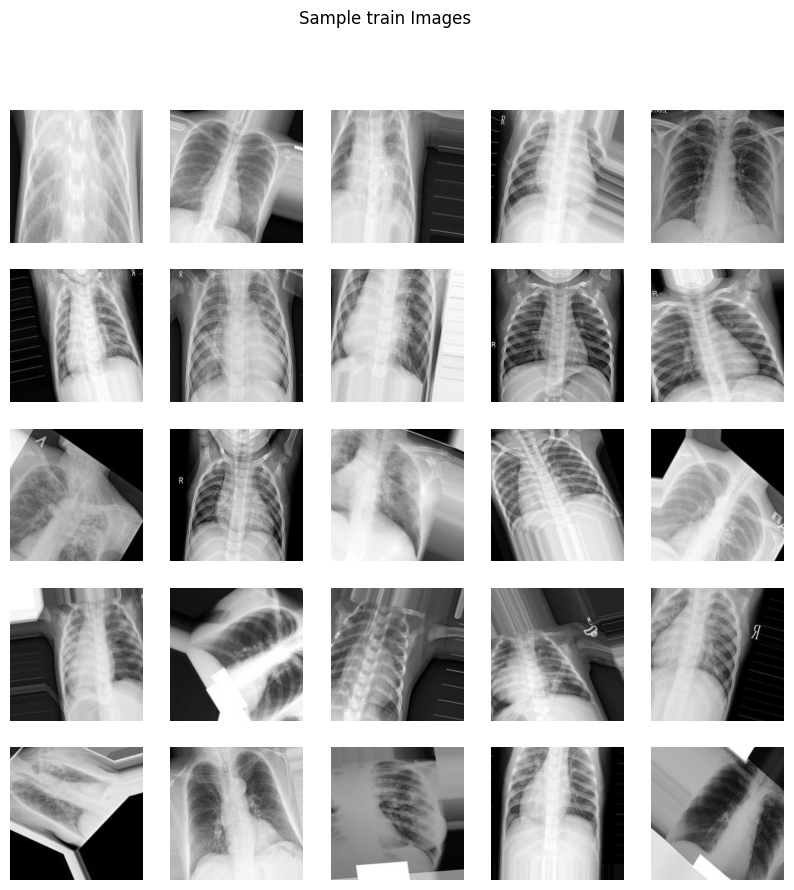

In [54]:
#Visual Montage - random 5 xrays
import random

def plot_montage(split, n_images=25):
    split_path = os.path.join(base_path, split)
    classes = os.listdir(split_path)
    all_images = []

    for cls in classes:
        cls_path = os.path.join(split_path, cls)
        all_images += [os.path.join(cls_path, img) for img in os.listdir(cls_path)]

    selected_images = random.sample(all_images, n_images)

    plt.figure(figsize=(10,10))
    for i, img_path in enumerate(selected_images):
        img = Image.open(img_path).convert('L')
        plt.subplot(5,5,i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Sample {split} Images')
    plt.show()

plot_montage('train')

In [89]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from skimage import filters, color, measure
from skimage.feature import hog
from sklearn.decomposition import PCA

In [75]:
# Set base path
base_path = '/kaggle/working/cleaned_dataset'

In [76]:
# Function to count images in each split (train, test, val)
def get_class_counts(split):
    split_path = os.path.join(base_path, split)
    classes = os.listdir(split_path)
    class_counts = {}
    for cls in classes:
        cls_path = os.path.join(split_path, cls)
        if os.path.isdir(cls_path):
            class_counts[cls] = len(os.listdir(cls_path))
    return class_counts

In [77]:
# Get counts for train, test, val
train_counts = get_class_counts('train')
test_counts = get_class_counts('test')
val_counts = get_class_counts('val')

In [78]:
# Plotting function for class distribution
def plot_distribution(counts, split_name):
    plt.figure(figsize=(8,6))
    plt.bar(counts.keys(), counts.values(), color='skyblue')
    plt.title(f'{split_name} Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

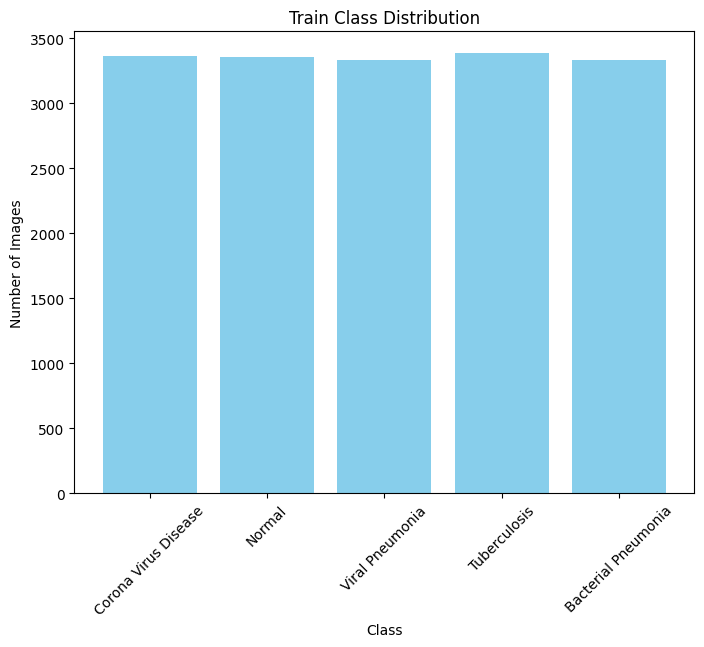

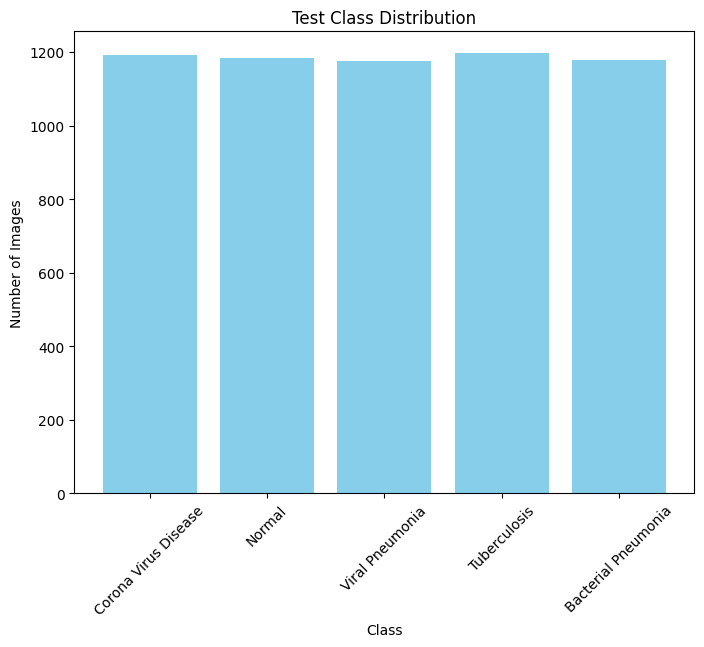

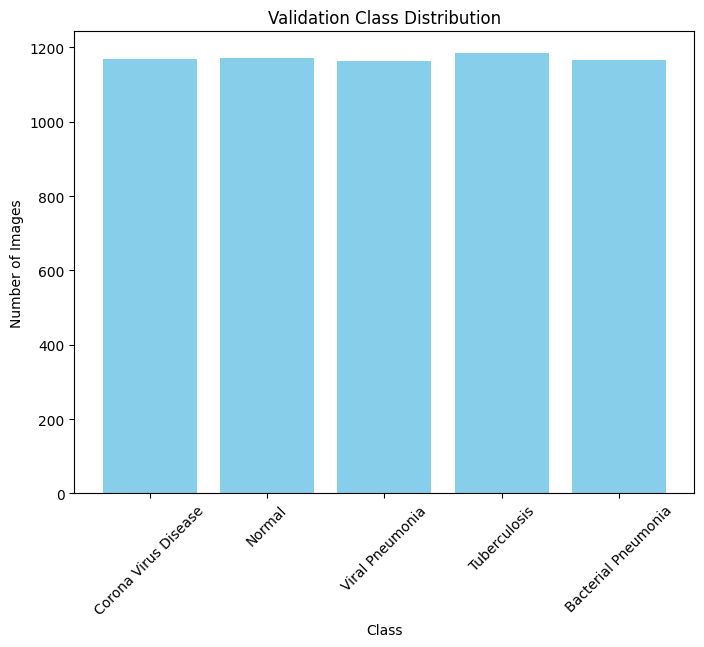

In [79]:
# Plot for each split
plot_distribution(train_counts, "Train")
plot_distribution(test_counts, "Test")
plot_distribution(val_counts, "Validation")

In [83]:
# Function to get image stats: width, height, brightness, aspect ratio, color features, sharpness, entropy
from skimage import measure
def get_image_stats(split):
    widths, heights, brightness, aspect_ratios, color_features, sharpness, entropy = [], [], [], [], [], [], []
    split_path = os.path.join(base_path, split)
    classes = os.listdir(split_path)
    for cls in classes:
        cls_path = os.path.join(split_path, cls)
        for img_name in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_name)
            try:
                img = Image.open(img_path).convert('RGB')  # Open as RGB
                img_gray = img.convert('L')  # Grayscale for brightness, sharpness, and entropy
                
                # Get image dimensions
                width, height = img.size
                widths.append(width)
                heights.append(height)
                aspect_ratios.append(width / height)
                
                # Brightness: Mean pixel value in grayscale
                brightness.append(np.array(img_gray).mean())
                
                # Image Sharpness: Using edge detection (Sobel filter)
                edges = filters.sobel(np.array(img_gray))
                sharpness.append(np.mean(edges))
                
                # Image Entropy
                img_entropy = measure.shannon_entropy(np.array(img_gray))
                entropy.append(img_entropy)
                
                # Color Features: Mean color values in R, G, B channels
                img_np = np.array(img)
                color_features.append(np.mean(img_np, axis=(0,1)))  # RGB mean

            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    return (widths, heights, brightness, aspect_ratios, color_features, sharpness, entropy)


In [88]:
# Get stats for train, test, val
train_widths, train_heights, train_brightness, train_aspect_ratios, train_color_features, train_sharpness, train_entropy = get_image_stats('train')
test_widths, test_heights, test_brightness, test_aspect_ratios, test_color_features, test_sharpness, test_entropy = get_image_stats('test')
val_widths, val_heights, val_brightness, val_aspect_ratios, val_color_features, val_sharpness, val_entropy = get_image_stats('val')


In [86]:
# Plot histograms for Width, Height, Aspect Ratio
def plot_histogram(data1, data2, data3, feature_name):
    plt.figure(figsize=(10,6))
    plt.hist(data1, bins=30, alpha=0.5, label='Train', color='blue')
    plt.hist(data2, bins=30, alpha=0.5, label='Test', color='green')
    plt.hist(data3, bins=30, alpha=0.5, label='Validation', color='red')
    plt.title(f'{feature_name} Distribution Across Train, Test, Validation')
    plt.xlabel(f'{feature_name} Value')
    plt.ylabel('Number of Images')
    plt.legend()
    plt.show()

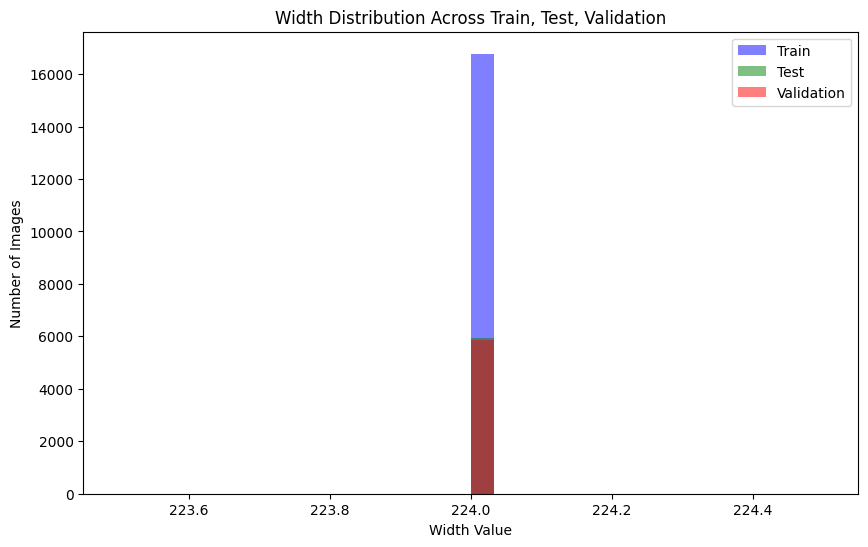

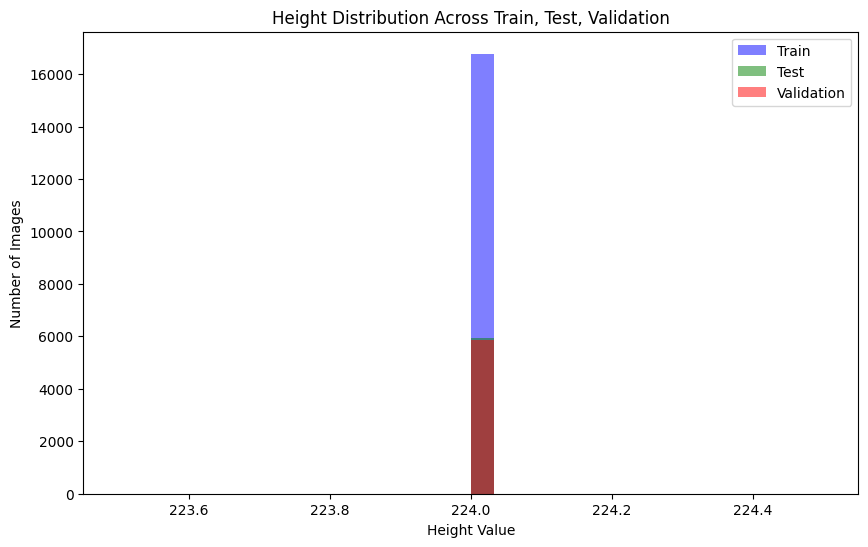

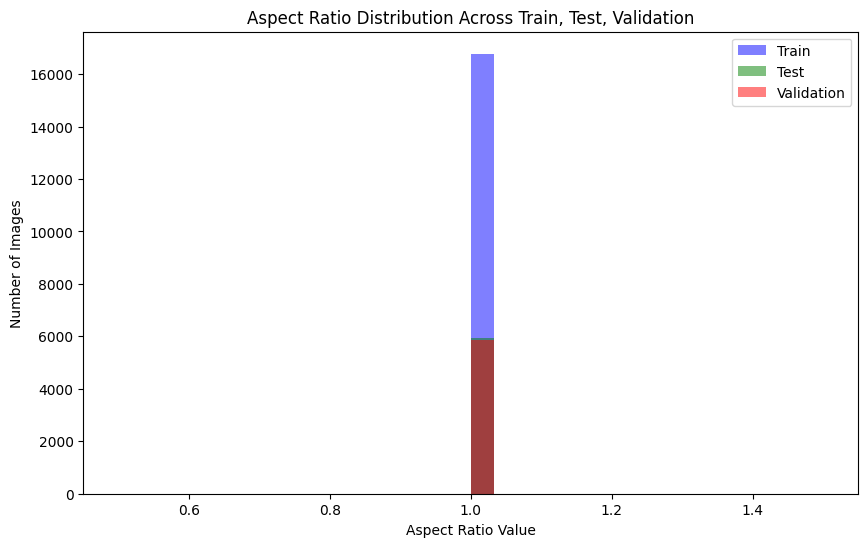

In [90]:
plot_histogram(train_widths, test_widths, val_widths, 'Width')
plot_histogram(train_heights, test_heights, val_heights, 'Height')
plot_histogram(train_aspect_ratios, test_aspect_ratios, val_aspect_ratios, 'Aspect Ratio')

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


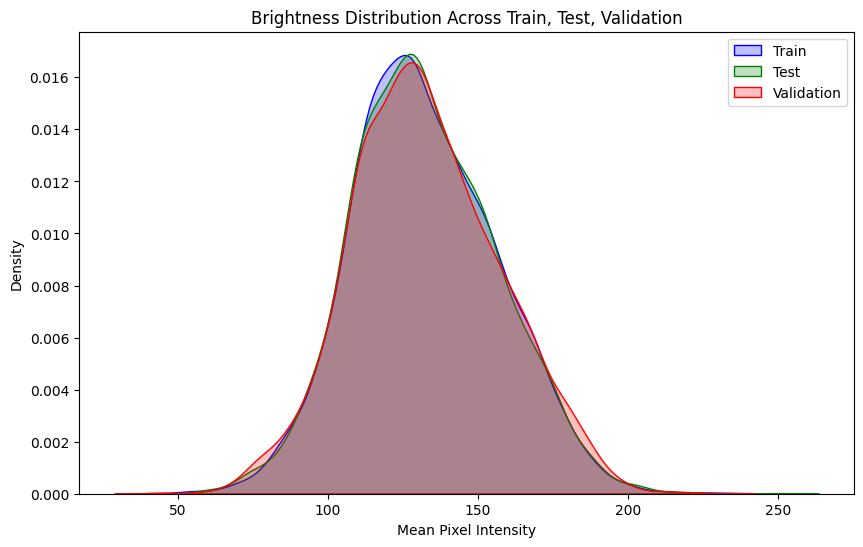

In [97]:
# Brightness Comparison (Density Plot)
plt.figure(figsize=(10,6))
sns.kdeplot(train_brightness, fill=True, label='Train', color='blue')
sns.kdeplot(test_brightness, fill=True, label='Test', color='green')
sns.kdeplot(val_brightness, fill=True, label='Validation', color='red')
plt.title('Brightness Distribution Across Train, Test, Validation')
plt.xlabel('Mean Pixel Intensity')
plt.ylabel('Density')
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


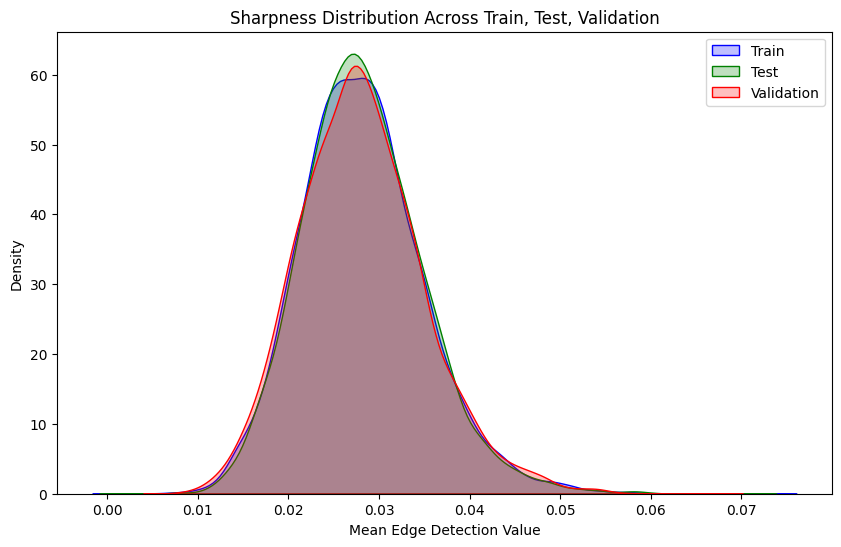

In [98]:
# Image Sharpness Comparison (Density Plot)
plt.figure(figsize=(10,6))
sns.kdeplot(train_sharpness, fill=True, label='Train', color='blue')
sns.kdeplot(test_sharpness, fill=True, label='Test', color='green')
sns.kdeplot(val_sharpness, fill=True, label='Validation', color='red')
plt.title('Sharpness Distribution Across Train, Test, Validation')
plt.xlabel('Mean Edge Detection Value')
plt.ylabel('Density')
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


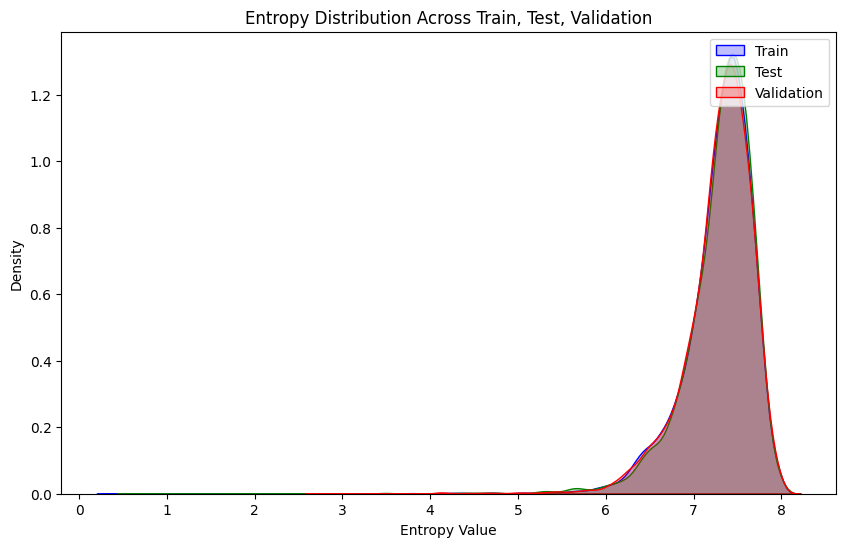

In [100]:
# Image Entropy Comparison (Density Plot)
plt.figure(figsize=(10,6))
sns.kdeplot(train_entropy, fill=True, label='Train', color='blue')
sns.kdeplot(test_entropy, fill=True, label='Test', color='green')
sns.kdeplot(val_entropy, fill=True, label='Validation', color='red')
plt.title('Entropy Distribution Across Train, Test, Validation')
plt.xlabel('Entropy Value')
plt.ylabel('Density')
plt.legend()
plt.show()

In [101]:
# PCA for Dimensionality Reduction
def plot_pca(data, feature_name):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data)
    
    plt.figure(figsize=(8,6))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
    plt.title(f'PCA of {feature_name}')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()

In [102]:
# Color Features (RGB means)
color_features_train = np.array(train_color_features)
color_features_test = np.array(test_color_features)
color_features_val = np.array(val_color_features)

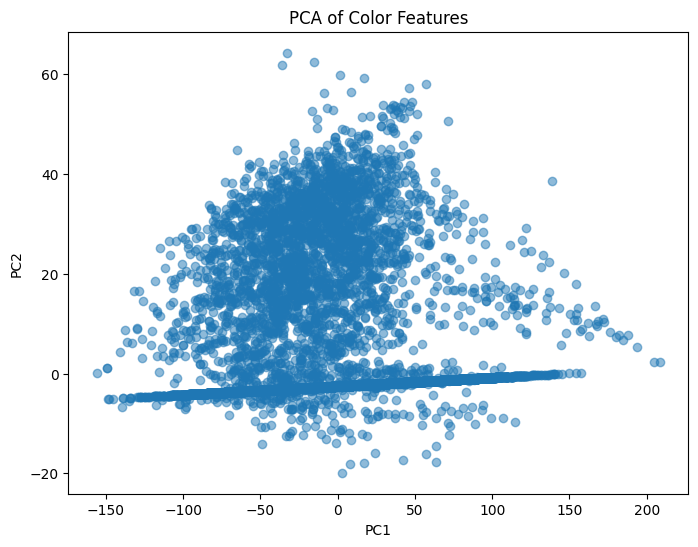

In [103]:
# Combine the RGB features and plot PCA
combined_color_features = np.concatenate([color_features_train, color_features_test, color_features_val], axis=0)
plot_pca(combined_color_features, 'Color Features')

In [104]:
# Summary Statistics for Width, Height, Brightness, Aspect Ratio
def print_summary_stats(data, name):
    print(f"{name} Stats:")
    print(f"Mean: {np.mean(data):.2f}, Std: {np.std(data):.2f}, Min: {np.min(data)}, Max: {np.max(data)}\n")

print_summary_stats(train_widths, "Width")
print_summary_stats(train_heights, "Height")
print_summary_stats(train_brightness, "Brightness")
print_summary_stats(train_aspect_ratios, "Aspect Ratio")
print_summary_stats(train_sharpness, "Sharpness")
print_summary_stats(train_entropy, "Entropy")

Width Stats:
Mean: 224.00, Std: 0.00, Min: 224, Max: 224

Height Stats:
Mean: 224.00, Std: 0.00, Min: 224, Max: 224

Brightness Stats:
Mean: 132.47, Std: 24.22, Min: 46.59731744260204, Max: 253.22458944515307

Aspect Ratio Stats:
Mean: 1.00, Std: 0.00, Min: 1.0, Max: 1.0

Sharpness Stats:
Mean: 0.03, Std: 0.01, Min: 0.001277110762216348, Max: 0.07316781287385082

Entropy Stats:
Mean: 7.27, Std: 0.44, Min: 0.38775814480210846, Max: 7.993544454025496



In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Box Plot Analysis function
def plot_boxplot(data1, data2, data3, feature_name):
    # Create DataFrame with combined data and labels for each dataset
    combined_data = pd.DataFrame({
        'Brightness': list(data1) + list(data2) + list(data3),
        'Dataset': ['Train'] * len(data1) + ['Test'] * len(data2) + ['Validation'] * len(data3)
    })
    
    # Plot the box plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Dataset', y='Brightness', data=combined_data)
    plt.title(f'{feature_name} Distribution Across Train, Test, Validation')
    plt.xlabel('Dataset')
    plt.ylabel(feature_name)
    plt.show()

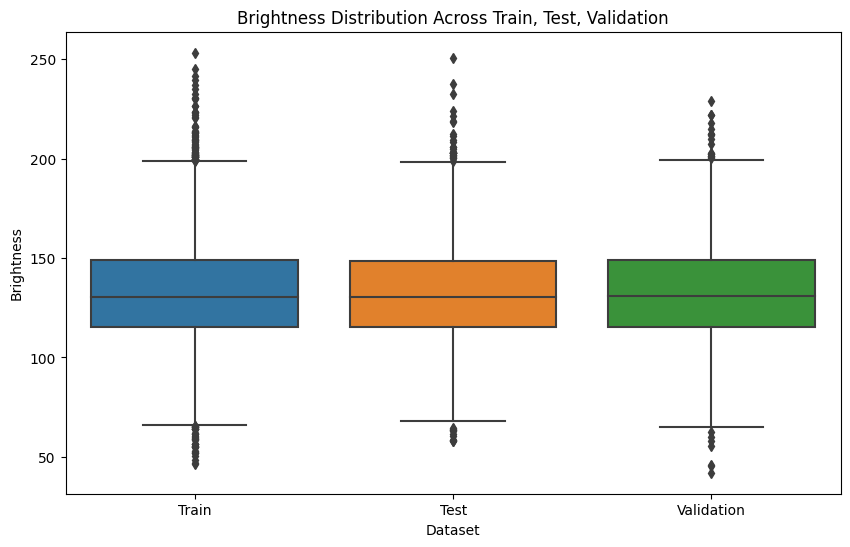

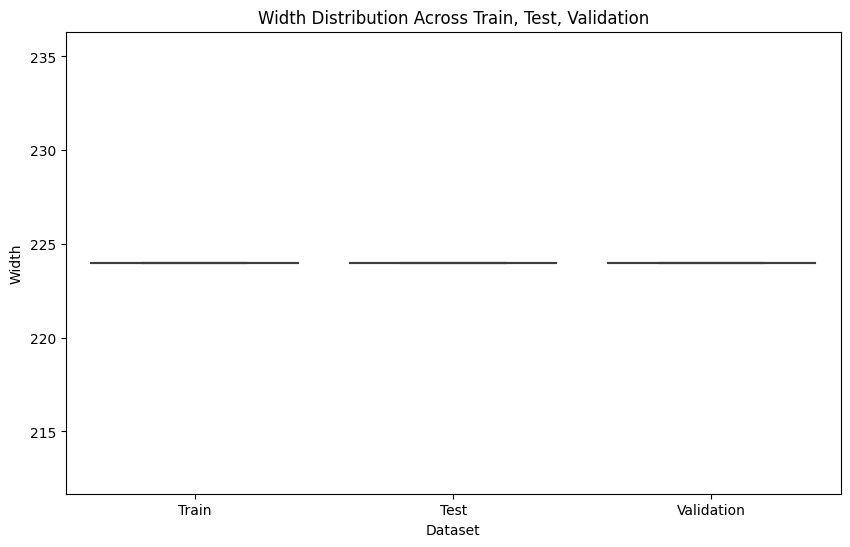

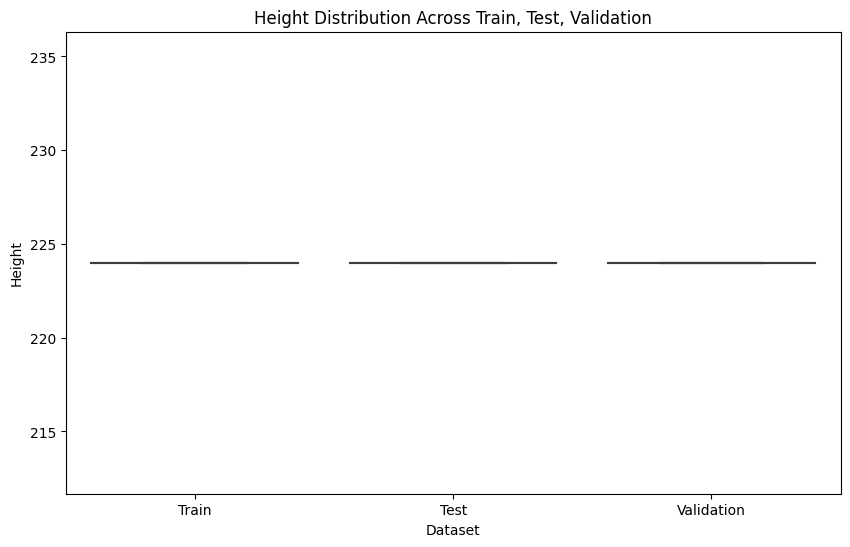

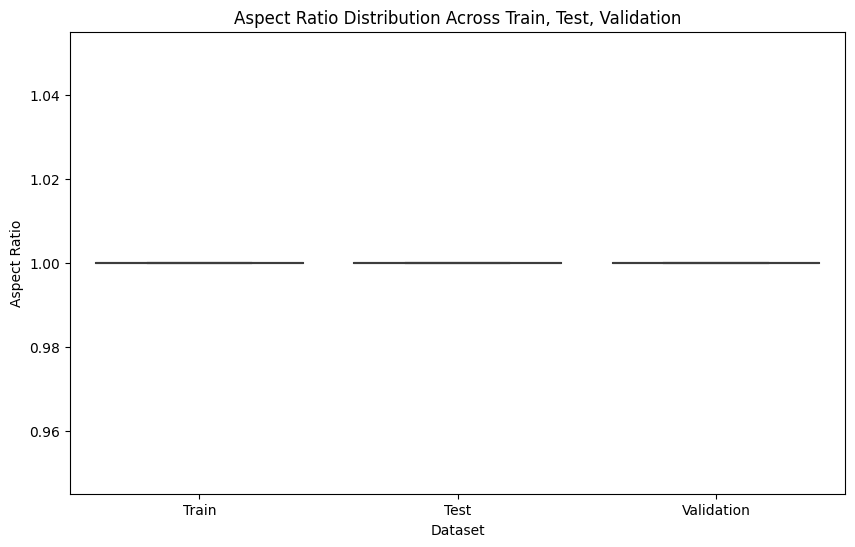

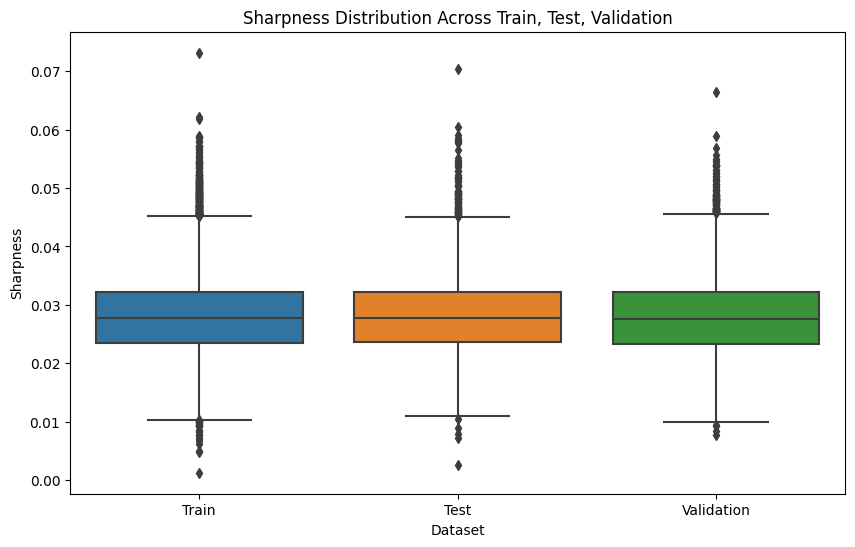

In [108]:
# Apply to Brightness, Width, Height, etc.
plot_boxplot(train_brightness, test_brightness, val_brightness, 'Brightness')
plot_boxplot(train_widths, test_widths, val_widths, 'Width')
plot_boxplot(train_heights, test_heights, val_heights, 'Height')
plot_boxplot(train_aspect_ratios, test_aspect_ratios, val_aspect_ratios, 'Aspect Ratio')
plot_boxplot(train_sharpness, test_sharpness, val_sharpness, 'Sharpness')

# Bivariate Analysis

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [124]:
#Correlation matrix and Heatmap
def plot_correlation_matrix(train_widths, test_widths, val_widths, 
                            train_heights, test_heights, val_heights,
                            train_brightness, test_brightness, val_brightness, 
                            train_aspect_ratios, test_aspect_ratios, val_aspect_ratios, 
                            train_sharpness, test_sharpness, val_sharpness):
    # Combine train, test, and validation datasets for correlation analysis
    combined_data = pd.DataFrame({
        'Width': list(train_widths) + list(test_widths) + list(val_widths),
        'Height': list(train_heights) + list(test_heights) + list(val_heights),
        'Brightness': list(train_brightness) + list(test_brightness) + list(val_brightness),
        'Aspect Ratio': list(train_aspect_ratios) + list(test_aspect_ratios) + list(val_aspect_ratios),
        'Sharpness': list(train_sharpness) + list(test_sharpness) + list(val_sharpness),
        'Dataset': ['Train'] * len(train_widths) + ['Test'] * len(test_widths) + ['Validation'] * len(val_widths)
    })
    
    # Exclude non-numeric columns ('Dataset') from the correlation matrix
    numeric_data = combined_data.drop(columns=['Dataset'])
    
    # Check for NaN or infinite values and handle them
    if numeric_data.isnull().values.any():
        print("Warning: Missing values detected. Filling missing values with column means.")
        numeric_data = numeric_data.fillna(numeric_data.mean())  # Fill NaNs with the mean of each column
    
    # Compute the correlation matrix
    correlation_matrix = numeric_data.corr()
    
    # Plot the heatmap for the correlation matrix
    plt.figure(figsize=(10, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix of Features')
    plt.show()


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


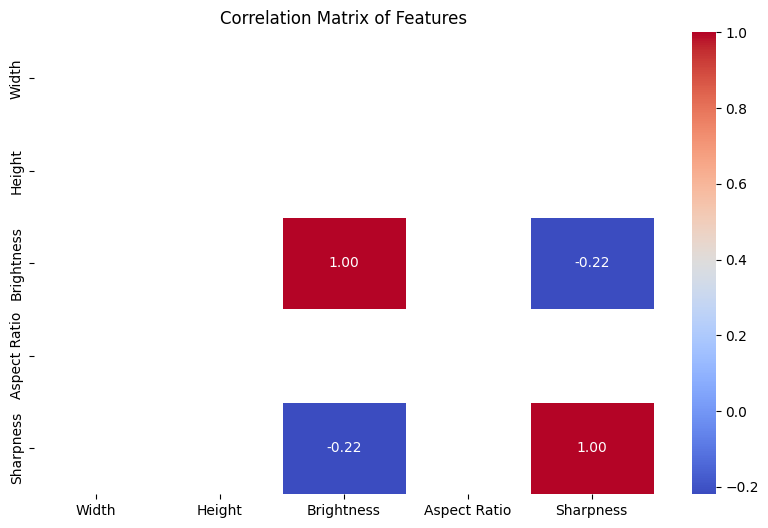

In [125]:
# Correlation Matrix and Heatmap
plot_correlation_matrix(train_widths, test_widths, val_widths, 
                        train_heights, test_heights, val_heights,
                        train_brightness, test_brightness, val_brightness, 
                        train_aspect_ratios, test_aspect_ratios, val_aspect_ratios, 
                        train_sharpness, test_sharpness, val_sharpness)


In [110]:
# Scatter Plot Analysis
def plot_scatter(x, y, x_label, y_label, title):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=x, y=y)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

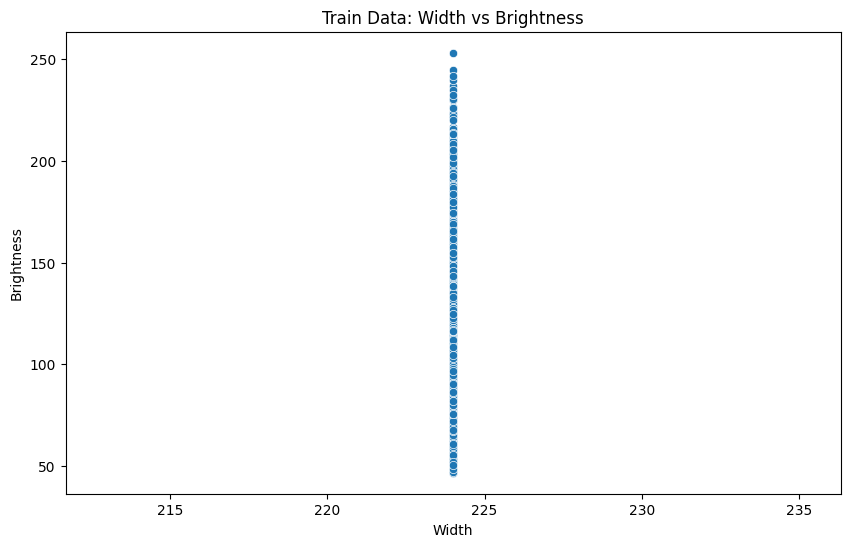

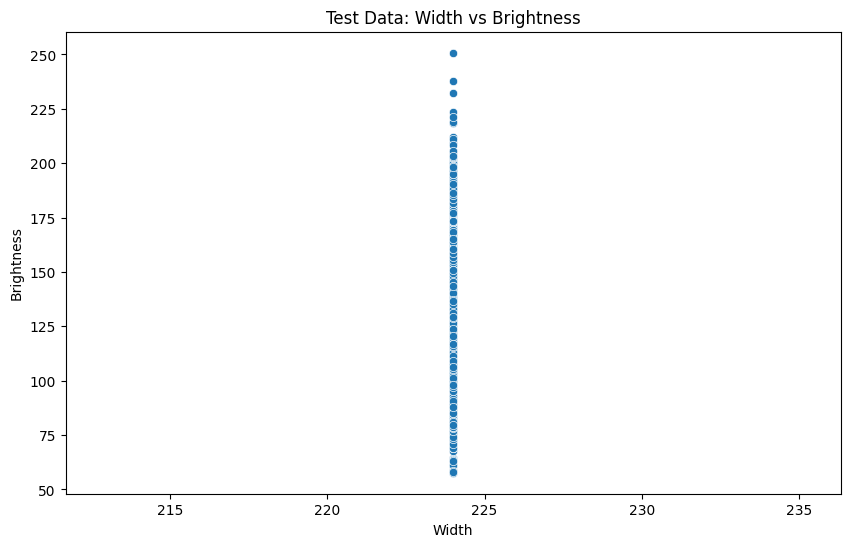

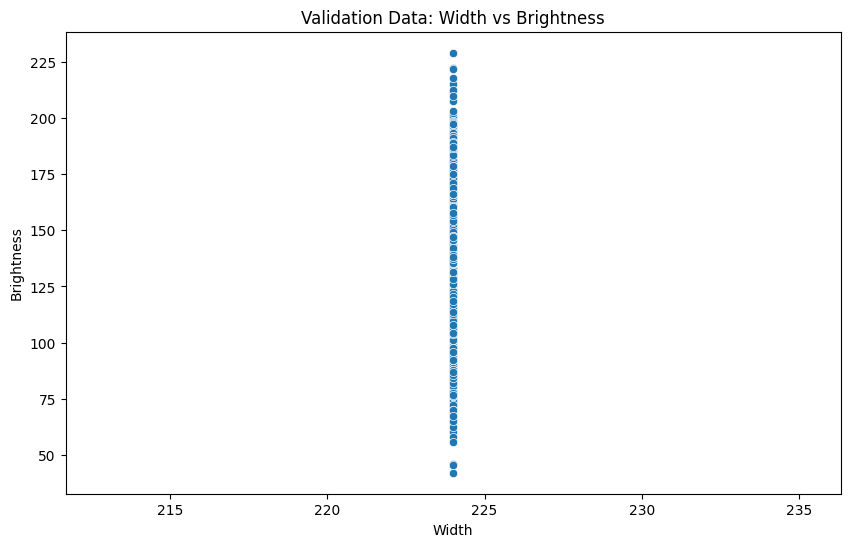

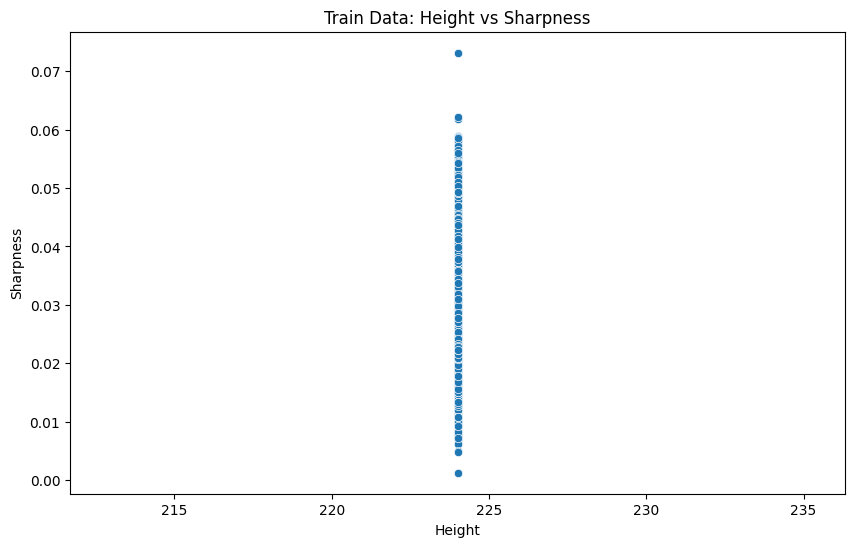

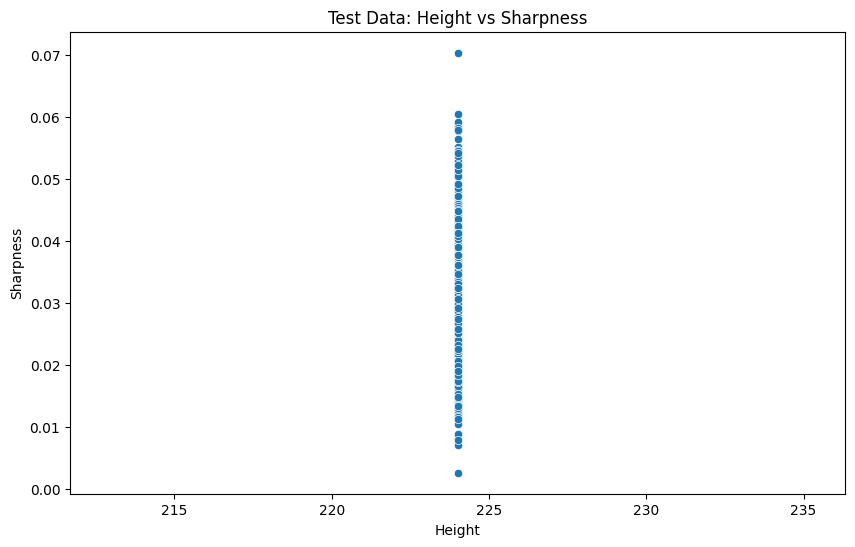

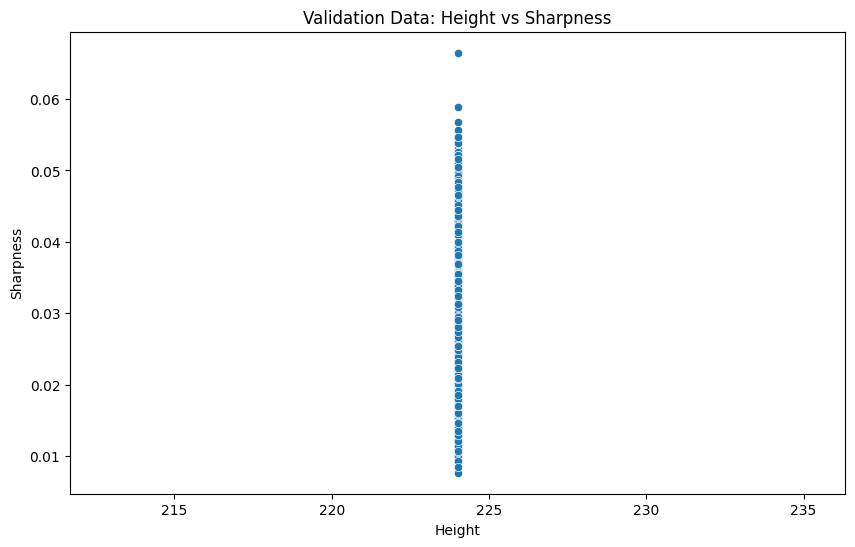

In [113]:
# 1. Scatter Plots for Bivariate Relationships
plot_scatter(train_widths, train_brightness, 'Width', 'Brightness', 'Train Data: Width vs Brightness')
plot_scatter(test_widths, test_brightness, 'Width', 'Brightness', 'Test Data: Width vs Brightness')
plot_scatter(val_widths, val_brightness, 'Width', 'Brightness', 'Validation Data: Width vs Brightness')

plot_scatter(train_heights, train_sharpness, 'Height', 'Sharpness', 'Train Data: Height vs Sharpness')
plot_scatter(test_heights, test_sharpness, 'Height', 'Sharpness', 'Test Data: Height vs Sharpness')
plot_scatter(val_heights, val_sharpness, 'Height', 'Sharpness', 'Validation Data: Height vs Sharpness')


In [128]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to plot the line chart for feature comparison
def plot_line_chart(train_data, test_data, val_data, feature_name):
    # Convert the lists to DataFrames
    train_df = pd.DataFrame(train_data, columns=[feature_name])
    test_df = pd.DataFrame(test_data, columns=[feature_name])
    val_df = pd.DataFrame(val_data, columns=[feature_name])
    
    # Line plot for each dataset
    plt.plot(train_df[feature_name], label='Train', color='blue', alpha=0.6)
    plt.plot(test_df[feature_name], label='Test', color='green', alpha=0.6)
    plt.plot(val_df[feature_name], label='Validation', color='red', alpha=0.6)
    
    # Labels and title
    plt.title(f'{feature_name} Comparison Across Datasets')
    plt.xlabel('Samples')
    plt.ylabel(feature_name)
    plt.legend()
    plt.show()

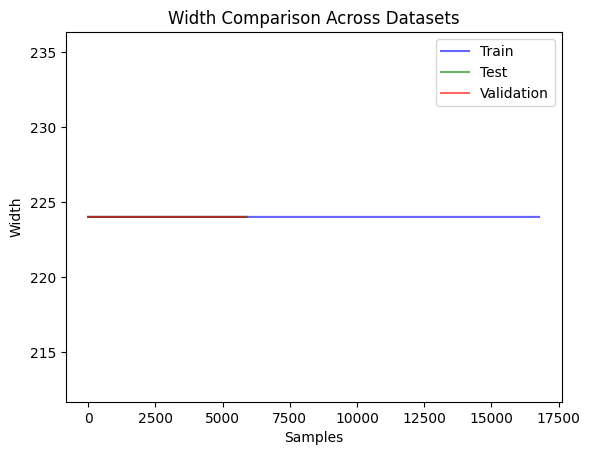

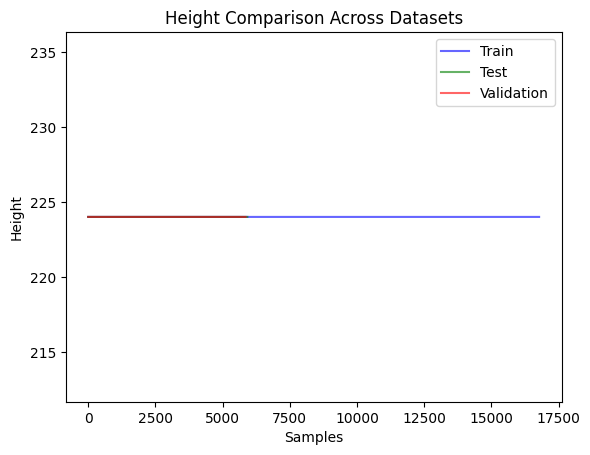

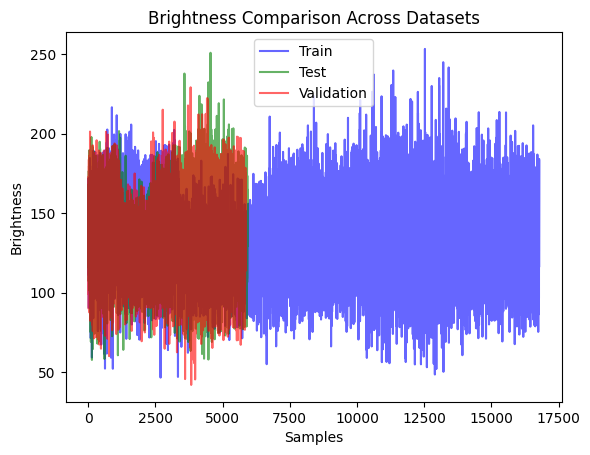

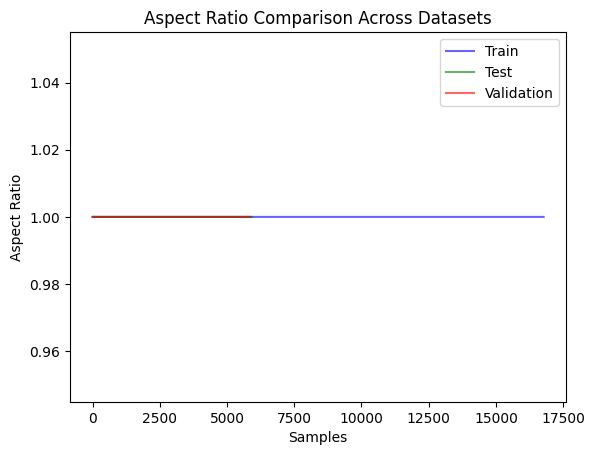

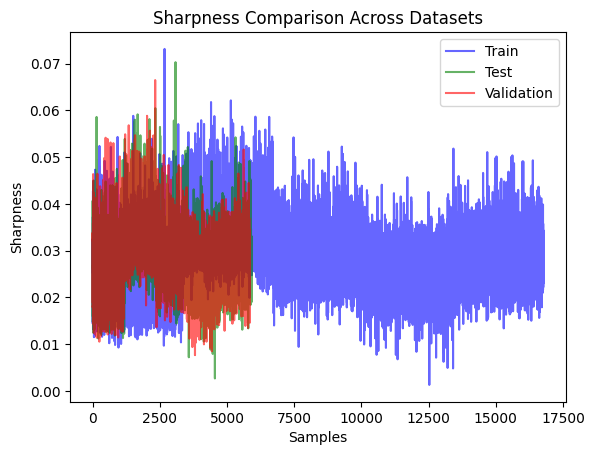

In [129]:
# Multiple Line Charts for Feature Comparison Across Datasets
plot_line_chart(train_widths, test_widths, val_widths, 'Width')
plot_line_chart(train_heights, test_heights, val_heights, 'Height')
plot_line_chart(train_brightness, test_brightness, val_brightness, 'Brightness')
plot_line_chart(train_aspect_ratios, test_aspect_ratios, val_aspect_ratios, 'Aspect Ratio')
plot_line_chart(train_sharpness, test_sharpness, val_sharpness, 'Sharpness')


# Multivariate Analysis

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [131]:
# Prepare DataFrame for PCA
train_data = pd.DataFrame({
    'Width': train_widths,
    'Height': train_heights,
    'Brightness': train_brightness,
    'Aspect Ratio': train_aspect_ratios,
    'Sharpness': train_sharpness,
    'Entropy': train_entropy
})

test_data = pd.DataFrame({
    'Width': test_widths,
    'Height': test_heights,
    'Brightness': test_brightness,
    'Aspect Ratio': test_aspect_ratios,
    'Sharpness': test_sharpness,
    'Entropy': test_entropy
})

val_data = pd.DataFrame({
    'Width': val_widths,
    'Height': val_heights,
    'Brightness': val_brightness,
    'Aspect Ratio': val_aspect_ratios,
    'Sharpness': val_sharpness,
    'Entropy': val_entropy
})

In [132]:
# Combine the datasets
combined_data = pd.concat([train_data, test_data, val_data], axis=0, ignore_index=True)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

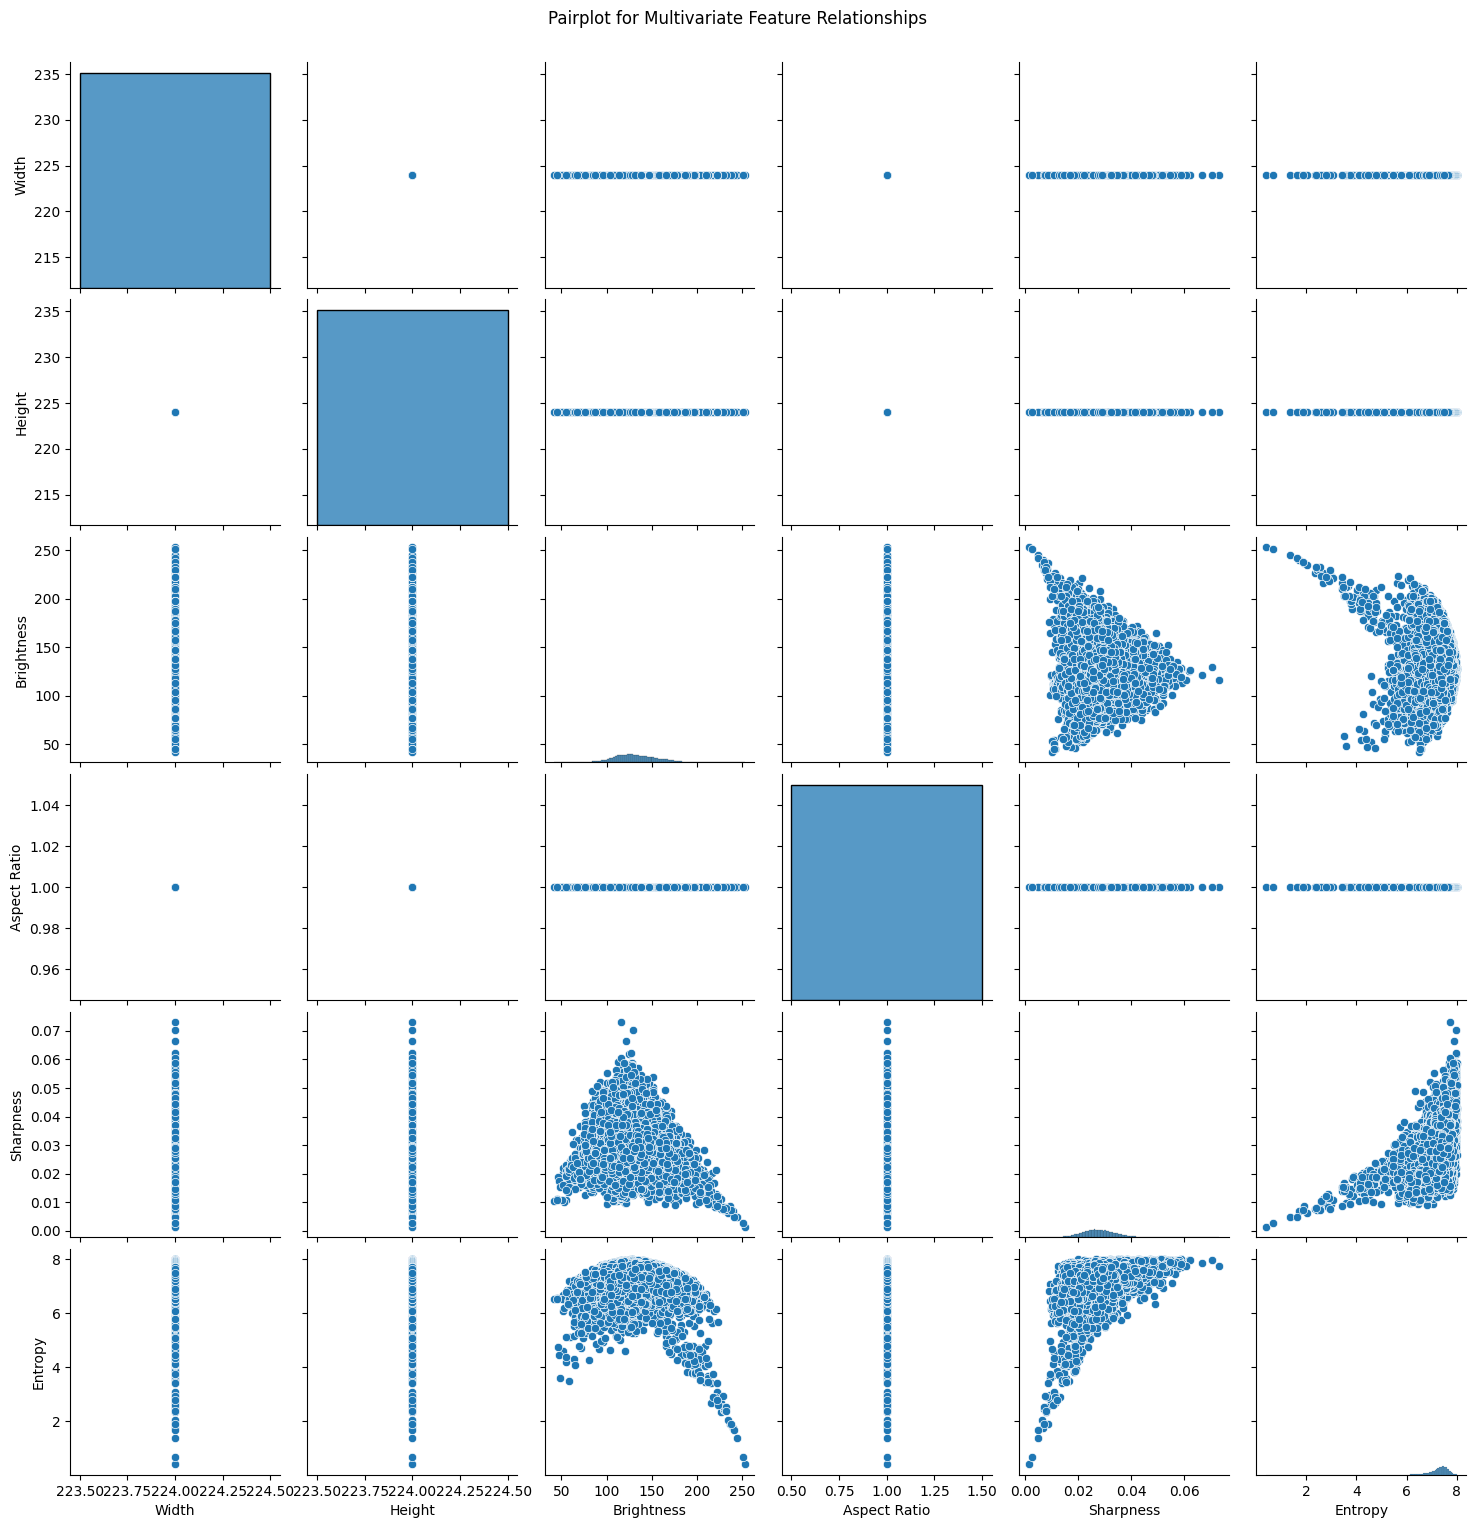

In [133]:
# 1. Pairplot for Visualizing Multivariate Distributions
sns.pairplot(combined_data)
plt.suptitle('Pairplot for Multivariate Feature Relationships', y=1.02)
plt.show()

In [134]:
# 2. PCA for Dimensionality Reduction and Visualization
pca = PCA(n_components=3)
pca_result = pca.fit_transform(combined_data)

# Add PCA components to DataFrame
combined_data['PCA1'] = pca_result[:, 0]
combined_data['PCA2'] = pca_result[:, 1]
combined_data['PCA3'] = pca_result[:, 2]

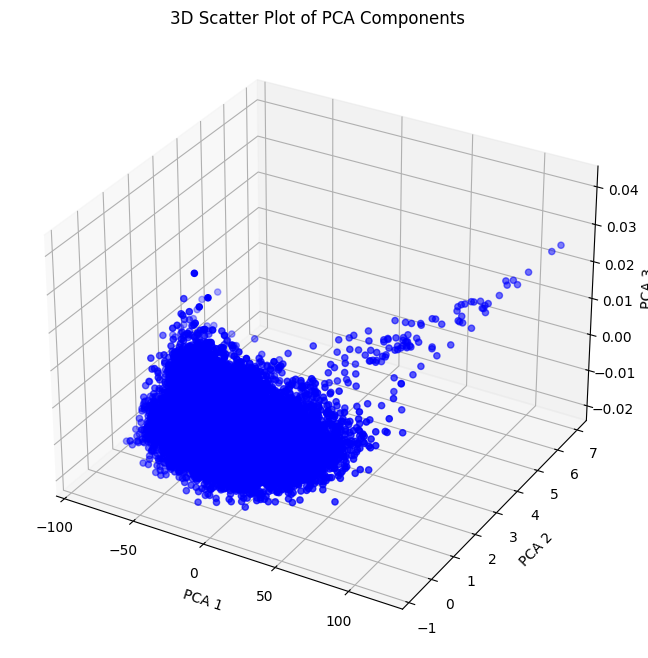

In [135]:
# 3. 3D Scatter Plot of the First Three Principal Components
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(combined_data['PCA1'], combined_data['PCA2'], combined_data['PCA3'], c='b', marker='o')

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')

plt.title('3D Scatter Plot of PCA Components')
plt.show()

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


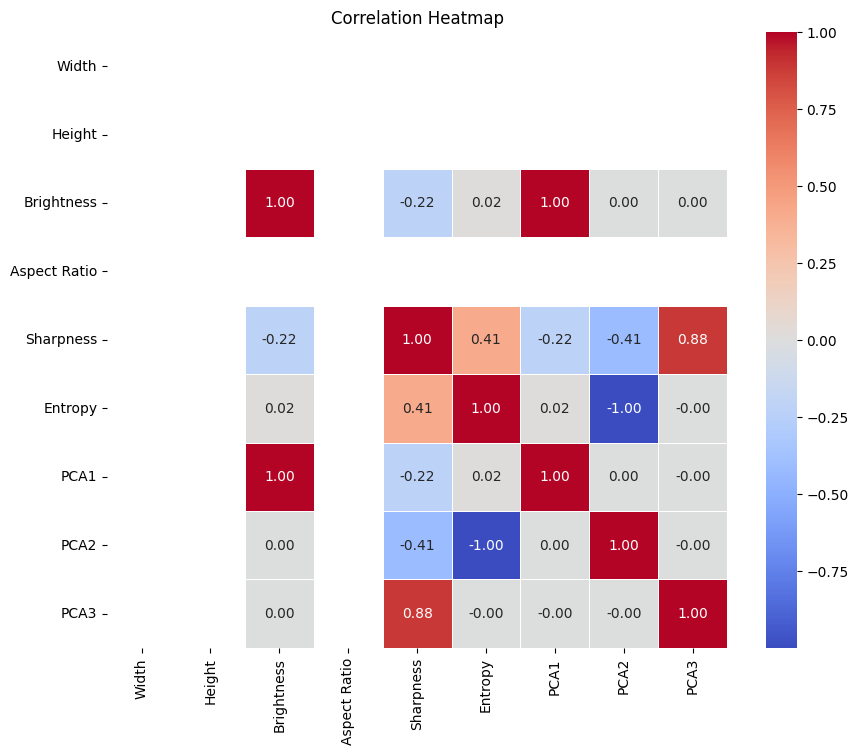

In [136]:
# 4. Heatmap of Correlations Among Features
corr_matrix = combined_data.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

/tmp/ipykernel_31/476109721.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_data.fillna(method='ffill', inplace=True)  # Forward fill to handle NaN values
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  wit

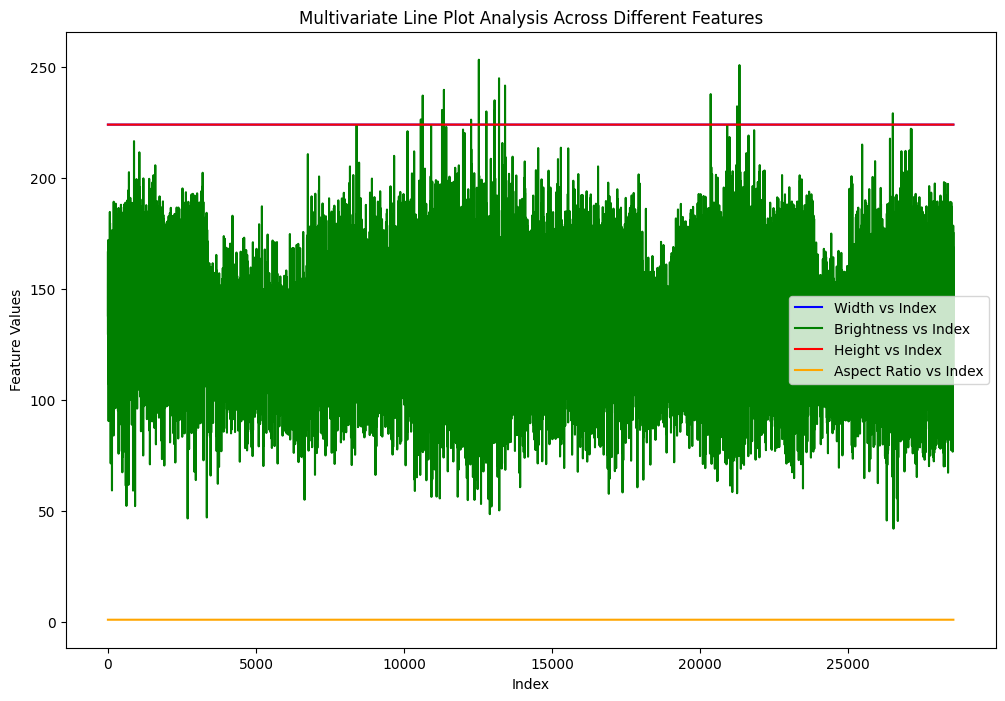

In [139]:
# Checking if the data contains any missing or infinite values and replace them with NaN
combined_data.replace([np.inf, -np.inf], np.nan, inplace=True)
combined_data.fillna(method='ffill', inplace=True)  # Forward fill to handle NaN values

# 5. Multivariate Line Plot for Trends Over Different Features
plt.figure(figsize=(12, 8))

# Plotting the relationships for multiple features
sns.lineplot(data=combined_data, x=combined_data.index, y='Width', label='Width vs Index', color='blue')
sns.lineplot(data=combined_data, x=combined_data.index, y='Brightness', label='Brightness vs Index', color='green')
sns.lineplot(data=combined_data, x=combined_data.index, y='Height', label='Height vs Index', color='red')
sns.lineplot(data=combined_data, x=combined_data.index, y='Aspect Ratio', label='Aspect Ratio vs Index', color='orange')

# Adjusting labels and title
plt.title('Multivariate Line Plot Analysis Across Different Features')
plt.xlabel('Index')
plt.ylabel('Feature Values')
plt.legend()
plt.show()


# **Methods and Findings (Assignment 2)**

Our methods involved applying cleaning, normalization, and transformation to the dataset to enhance its quality before augmentation. Augmentation techniques such as rotation, flipping, and zooming were then used to increase the dataset size and improve model generalization. After augmentation, we again applied cleaning, normalization, and transformation to ensure consistency across all images. Finally, the dataset underwent validation to confirm its quality and readiness for deep learning applications. Our findings indicate that this structured preprocessing pipeline improves data integrity, reduces noise, and enhances model performance by providing diverse and well-processed training samples.

# **Methodology (Assignment 3)**

In univariate analysis, we examined features like width, height, brightness, aspect ratio, sharpness, entropy, and color features using summary statistics, histograms, box plots, and density plots to understand their distribution and variability. These variables were chosen for their direct impact on image quality and characteristics. In bivariate analysis, we explored relationships between pairs of features through scatter plots, correlation matrices, heatmaps, and line charts to identify correlations and dependencies. Finally, in multivariate analysis, we analyzed trends and interactions across multiple features simultaneously using line charts and other techniques to detect complex patterns within the data, aiding in a deeper understanding of the dataset's structure and behavior across training, testing, and validation.